# Sources:
https://www.kaggle.com/datasets/paultimothymooney/zillow-house-price-data?resource=download

https://en.wikipedia.org/wiki/Distributed_lag

https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/


# Introduction
The objective of this project is to determine if college educated people leaving / entering a city plays a role in the following year's rent prices. 

This project is done with the knowledge that the percent of a city which is college educated is strongly correlated with rent prices, but this project will focus on if a *change* in proportion of college educated people results in a statistically significant *change* of rent prices. The goal is to determine if college educated people moving in/out of a city should be considered as a variable for predicting what rent prices will do in coming years.

# Process
The first objective is to pull, clean, and organize the data. I will pull data from the census and kaggle to gather proportion of college educated people by city and rent in each city, respectively.

The next objective is to perform exploratory data analysis. This will be done by looking at summary statistics from tables, correlation matrices, and scatterplots with regressions superimposed. 

The last step is modeling. I will use a linear regression (OLS) if there is a linear relationship and a non-linear regression model (random forest) if there isn't. 

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

In [3]:
raw = pd.read_csv('/Users/samuelmurphy/Desktop/econ_143_final_project/median_rental_price/City_MedianRentalPrice_3Bedroom_2010.csv')
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
raw['city_state'] = raw.RegionName  + ", " + raw.State
raw

,Unnamed: 0,RegionName,State,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,city_state
0,0,New York,NY,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,2800,2828.666667,2940.833333,2781.833333,2701.25,2698.583333,"New York, NY"
1,1,Los Angeles,CA,2577.545455,2700.208333,2538.75,2497.083333,2801.541667,3260.25,3457.875,3611.833333,3637.875,3708.125000,"Los Angeles, CA"
2,2,Houston,TX,#DIV/0!,#DIV/0!,1395,1344.583333,1432.666667,1578.916667,1599.75,1577.458333,1602.166667,1608.833333,"Houston, TX"
3,3,Chicago,IL,1924.5,1759.25,1657.333333,1737.5,1873.583333,1910.541667,1889.583333,1920.416667,2024.583333,2065.416667,"Chicago, IL"
4,4,San Antonio,TX,1119.375,1099.375,1126.5,1215.166667,1232.083333,1287.916667,1301.041667,1358.083333,1390.666667,1444.500000,"San Antonio, TX"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,985,Siesta Key,FL,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,4925,4855,4820.416667,"Siesta Key, FL"
986,986,Glasgow Village,MO,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,791.6818182,800.4166667,819.958333,"Glasgow Village, MO"
987,987,Bridgehampton,NY,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,36227.27273,30729.16667,28756.833330,"Bridgehampton, NY"
988,988,Montauk,NY,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,#DIV/0!,19861.11111,20215.250000,"Montauk, NY"


In [4]:
%cd /Users/samuelmurphy/Desktop/econ_143_final_project/college_rates_plus_pop

for year in range(2010, 2019 + 1):
    if year == 2010: # initializing the df
        df = pd.read_csv("/Users/samuelmurphy/Desktop/econ_143_final_project/college_rates_plus_pop/df_{}.csv".format(year))
        df = df.iloc[:, [1,9,31, 35, 37, 41, 43, 47, 49, 53, 229]] # only selecting relevent columns
        df = df.set_axis(["pop_18_to_24","percent_of_bach_18_24", "pop_25_to_34", "percent_of_bach_25_34", "pop_35_to_44", 
        "percent_of_bach_35_to_44", "pop_45_to_64", "percent_of_bach_45_to_64", 
        "pop_65_and_over", "percent_of_bach_65_and_over","city_state"], axis = 1)
        column_to_reorder = df.pop("city_state")
        df.insert(0, "city_state",column_to_reorder)
        df['percent_of_bach_18_24'] = ((df['percent_of_bach_18_24'] / 100) * df['pop_18_to_24']) / df['pop_18_to_24']
        df['percent_of_bach_25_34'] = ((df['percent_of_bach_25_34'] / 100) * df['pop_25_to_34']) / df['pop_25_to_34']
        df['percent_of_bach_35_to_44'] = ((df['percent_of_bach_35_to_44'] / 100) * df['pop_35_to_44']) / df['pop_35_to_44']
        df['percent_of_bach_45_to_64'] = ((df['percent_of_bach_45_to_64'] / 100) * df['pop_45_to_64']) / df['pop_45_to_64']
        df['percent_of_bach_65_and_over'] = ((df['percent_of_bach_65_and_over'] / 100) * df['pop_65_and_over']) / df['pop_65_and_over']
        df['year'] = year

    elif year == 2011:
        pp = pd.read_csv("/Users/samuelmurphy/Desktop/econ_143_final_project/college_rates_plus_pop/df_{}.csv".format(year))
        pp = pp.iloc[:, [1,9,31, 35, 37, 41, 43, 47, 49, 53, 229]] # only selecting relevent columns
        pp = pp.set_axis(["pop_18_to_24","percent_of_bach_18_24", "pop_25_to_34", "percent_of_bach_25_34", "pop_35_to_44", 
        "percent_of_bach_35_to_44", "pop_45_to_64", "percent_of_bach_45_to_64", 
        "pop_65_and_over", "percent_of_bach_65_and_over","city_state"], axis = 1)
        column_to_reorder = pp.pop("city_state")
        pp.insert(0, "city_state",column_to_reorder)
        pp['percent_of_bach_18_24'] = ((pp['percent_of_bach_18_24'] / 100) * pp['pop_18_to_24']) / pp['pop_18_to_24']
        pp['percent_of_bach_25_34'] = ((pp['percent_of_bach_25_34'] / 100) * pp['pop_25_to_34']) / pp['pop_25_to_34']
        pp['percent_of_bach_35_to_44'] = ((pp['percent_of_bach_35_to_44'] / 100) * pp['pop_35_to_44']) / pp['pop_35_to_44']
        pp['percent_of_bach_45_to_64'] = ((pp['percent_of_bach_45_to_64'] / 100) * pp['pop_45_to_64']) / pp['pop_45_to_64']
        pp['percent_of_bach_65_and_over'] = ((pp['percent_of_bach_65_and_over'] / 100) * pp['pop_65_and_over']) / pp['pop_65_and_over']
        pp['year'] = year
        df = df.append(pp)
    
    elif year in range(2012, 2015):
        pp = pd.read_csv("/Users/samuelmurphy/Desktop/econ_143_final_project/college_rates_plus_pop/df_{}.csv".format(year))
        pp = pp.iloc[:, [1,2, 10,32, 36, 38, 42, 44, 48, 50, 54]] # only selecting relevent columns
        pp = pp.set_axis(["city_state", "pop_18_to_24","percent_of_bach_18_24", "pop_25_to_34", "percent_of_bach_25_34", "pop_35_to_44", 
        "percent_of_bach_35_to_44", "pop_45_to_64", "percent_of_bach_45_to_64", 
        "pop_65_and_over", "percent_of_bach_65_and_over"], axis = 1)
        pp.drop(pp.index[pp['pop_18_to_24'] == "N"], inplace=True)
        pp.pop_18_to_24 = pp.pop_18_to_24.astype(int)
        pp.pop_25_to_34 = pp.pop_25_to_34.astype(int)
        pp.pop_35_to_44 = pp.pop_35_to_44.astype(int)
        pp.pop_45_to_64 = pp.pop_45_to_64.astype(int)
        pp.pop_65_and_over = pp.pop_65_and_over.astype(int)
        pp.percent_of_bach_18_24 = pp.percent_of_bach_18_24.astype(float)
        pp.percent_of_bach_25_34 = pp.percent_of_bach_25_34.astype(float)
        pp.percent_of_bach_35_to_44 = pp.percent_of_bach_35_to_44.astype(float)
        pp.percent_of_bach_45_to_64 = pp.percent_of_bach_45_to_64.astype(float)
        pp.percent_of_bach_65_and_over = pp.percent_of_bach_65_and_over.astype(float)
        pp['percent_of_bach_18_24'] = ((pp['percent_of_bach_18_24'] / 100) * pp['pop_18_to_24']) / pp['pop_18_to_24']
        pp['percent_of_bach_25_34'] = ((pp['percent_of_bach_25_34'] / 100) * pp['pop_25_to_34']) / pp['pop_25_to_34']
        pp['percent_of_bach_35_to_44'] = ((pp['percent_of_bach_35_to_44'] / 100) * pp['pop_35_to_44']) / pp['pop_35_to_44']
        pp['percent_of_bach_45_to_64'] = ((pp['percent_of_bach_45_to_64'] / 100) * pp['pop_45_to_64']) / pp['pop_45_to_64']
        pp['percent_of_bach_65_and_over'] = ((pp['percent_of_bach_65_and_over'] / 100) * pp['pop_65_and_over']) / pp['pop_65_and_over']
        pp['year'] = year
        df = df.append(pp)

    else:
        pp = pd.read_csv("/Users/samuelmurphy/Desktop/econ_143_final_project/college_rates_plus_pop/df_{}.csv".format(year))
        pp = pp.iloc[:, [1,2, 10,32, 36, 38, 42, 44, 48, 50, 54]] # only selecting relevent columns
        pp = pp.set_axis(["city_state", "pop_18_to_24","percent_of_bach_18_24", "pop_25_to_34", "percent_of_bach_25_34", "pop_35_to_44", 
        "percent_of_bach_35_to_44", "pop_45_to_64", "percent_of_bach_45_to_64", 
        "pop_65_and_over", "percent_of_bach_65_and_over"], axis = 1)
        pp.drop(pp.index[pp['pop_18_to_24'] == "N"], inplace=True)
        pp.pop_18_to_24 = pp.pop_18_to_24.astype(int)
        pp.pop_25_to_34 = pp.pop_25_to_34.astype(int)
        pp.pop_35_to_44 = pp.pop_35_to_44.astype(int)
        pp.pop_45_to_64 = pp.pop_45_to_64.astype(int)
        pp.pop_65_and_over = pp.pop_65_and_over.astype(int)
        pp.percent_of_bach_18_24 = pp.percent_of_bach_18_24.astype(float)
        pp.percent_of_bach_25_34 = pp.percent_of_bach_25_34.astype(float)
        pp.percent_of_bach_35_to_44 = pp.percent_of_bach_35_to_44.astype(float)
        pp.percent_of_bach_45_to_64 = pp.percent_of_bach_45_to_64.astype(float)
        pp.percent_of_bach_65_and_over = pp.percent_of_bach_65_and_over.astype(float)
        pp['percent_of_bach_18_24'] = pp['percent_of_bach_18_24'] / pp['pop_18_to_24']
        pp['percent_of_bach_25_34'] = pp['percent_of_bach_25_34'] / pp['pop_25_to_34']
        pp['percent_of_bach_35_to_44'] = pp['percent_of_bach_35_to_44'] / pp['pop_35_to_44']
        pp['percent_of_bach_45_to_64'] = pp['percent_of_bach_45_to_64'] / pp['pop_45_to_64']
        pp['percent_of_bach_65_and_over'] = pp['percent_of_bach_65_and_over'] / pp['pop_65_and_over']
        pp['year'] = year
        df = df.append(pp)

df['total_pop'] = df['pop_18_to_24'] + df['pop_25_to_34'] + df['pop_35_to_44'] +df['pop_45_to_64'] + df['pop_65_and_over']
df['percent_of_town_with_bachelor_degree'] = (df['percent_of_bach_18_24'] + df['percent_of_bach_25_34'] + df['percent_of_bach_35_to_44'] +
 df['percent_of_bach_45_to_64'] + df['percent_of_bach_65_and_over']) / 5
large_city_cutoff = np.percentile(df['total_pop'], 80)
small_city_cutoff = np.percentile(df['total_pop'], 20)

size = []
for row in df['total_pop']:
    if row < small_city_cutoff:
        size.append("Small")
    elif row >= small_city_cutoff and row <= large_city_cutoff:
        size.append("Medium")
    else:
        size.append("Large")
df['city_size'] = size
df.city_size = df.city_size.astype('category')
df = df[['city_state', "year", "percent_of_town_with_bachelor_degree", "city_size", "total_pop"]]
df.city_size.value_counts(), df.describe() # Summary statistics of the census data

/Users/samuelmurphy/Desktop/econ_143_final_project/college_rates_plus_pop


(Medium    3547
 Large     1183
 Small     1183
 Name: city_size, dtype: int64,
               year  percent_of_town_with_bachelor_degree     total_pop
 count  5913.000000                           5913.000000  5.913000e+03
 mean   2014.615593                              0.282773  1.500457e+05
 std       2.870845                              0.127122  3.421150e+05
 min    2010.000000                              0.030800  3.940500e+04
 25%    2012.000000                              0.188924  6.057700e+04
 50%    2015.000000                              0.258723  7.983000e+04
 75%    2017.000000                              0.355984  1.323600e+05
 max    2019.000000                              0.796299  6.833629e+06)

The above cell pulls in data from a series of 10 CSVs which were downloaded from the US census website. Each CSV has slightly different formatting, which explains much of the above code. 

Summary statistics is also displayed, showing the distribution of college graduate percentages across cities, city populations and the time-frame.

In [5]:


df = df[(df['city_state'].str.contains("city", na = False))]  # the dataset origionally included towns, counties and provinces

f = lambda x: x.replace(" city", "")
df['city_state'] = df['city_state'].map(f)
just_names = df[['city_state']]
len(just_names.city_state.str.replace("(,).*","").unique()) == len(just_names.city_state.unique()) 
state_converter = pd.read_csv('/Users/samuelmurphy/Desktop/econ_143_final_project/csvData.csv')
# Due to cities having the same name across different states, we need to find a joinable column to match the full name of the states to the 2 letter abbrebiation.

just_names['state_names'] = just_names.city_state.str.partition(',')[2]
just_names['city_names'] = just_names.city_state.str.replace("(,).*","")

state_converter['State'] = state_converter['State'].str.strip()
just_names['state_names'] = just_names['state_names'].str.strip()
new_df = pd.DataFrame(columns=["abv"])
for i_0, r_0 in just_names.iterrows():
    for i_i, r_1 in state_converter.iterrows():
        if r_0['state_names'] ==  r_1['State']:
            new_df = new_df.append(r_1)
            
new_df = new_df.Code
new_df.reset_index()
just_names['names_abbreviated'] = list(new_df)
just_names['total_abv'] = just_names['city_names'] + ", " + just_names['names_abbreviated']
df['city_state'] = just_names.total_abv

met = raw[['city_state','2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']]
met = pd.melt(met, id_vars = ['city_state'])
met.variable = met.variable.astype(int)

x = pd.merge(df, met, how = "inner", left_on = ["city_state", "year"], right_on = ["city_state", "variable"])
x = x.replace("#DIV/0!", np.nan)

x = x.drop(columns="variable")
x = x.rename(columns={"value" : "rent_over_time"})
x

,city_state,year,percent_of_town_with_bachelor_degree,city_size,total_pop,rent_over_time
0,"Birmingham, AL",2010,0.178200,Large,166662,NaN
1,"Hoover, AL",2010,0.494800,Small,57309,NaN
2,"Mobile, AL",2010,0.230800,Medium,149802,937.5
3,"Montgomery, AL",2010,0.263000,Large,155638,NaN
4,"Chandler, AZ",2010,0.306200,Large,171207,NaN
...,...,...,...,...,...,...
4291,"Yakima, WA",2019,0.155041,Medium,67789,1404.583333
4292,"Kenosha, WI",2019,0.221204,Medium,75879,1240.208333
4293,"Madison, WI",2019,0.513775,Large,219343,1657.916667
4294,"Milwaukee, WI",2019,0.228507,Large,440652,1128.333333


The above code block merges data pulled from the US census on populations and college graduation rates of each US city and a dataset found on kaggle showing rent prices of each city. An inner join was done to get only the cities that had data in both dataframes. 

In [6]:
shifted = x
shifted['lagged_percent_with_bach_degree (t + 1)'] = shifted.groupby(['city_state'])['percent_of_town_with_bachelor_degree'].shift(+1) # lagged in the forward direction.
shifted['rent_over_time'] = shifted['rent_over_time'].astype(float, errors = 'ignore')
shifted['pct_change_of_pop_with_bach_degree'] = shifted.groupby(['city_state'])['lagged_percent_with_bach_degree (t + 1)'].pct_change()
shifted['pct_change_in_rent'] = shifted.groupby(['city_state'])['rent_over_time'].pct_change()
shifted = shifted.dropna()

means_added = pd.DataFrame(shifted.groupby('city_state')['percent_of_town_with_bachelor_degree'].agg('mean')).reset_index()
shifted = pd.merge(shifted, means_added, how = "left", left_on="city_state", right_on="city_state")
shifted[shifted['city_state'] == "Mobile, AL"]
shifted = shifted.rename(columns={"percent_of_town_with_bachelor_degree_y" : "Average_Rent_of_City", "percent_of_town_with_bachelor_degree_x" : "percent_of_town_with_bachelor_degree_for_year_x"})
shifted

,city_state,year,percent_of_town_with_bachelor_degree_for_year_x,city_size,total_pop,rent_over_time,lagged_percent_with_bach_degree (t + 1),pct_change_of_pop_with_bach_degree,pct_change_in_rent,Average_Rent_of_City
0,"Birmingham, AL",2012,0.209800,Large,166050,757.916667,0.199200,0.117845,-0.044392,0.233930
1,"Mobile, AL",2012,0.226000,Medium,149596,892.833333,0.228200,-0.011265,-0.073183,0.244375
2,"Chandler, AZ",2012,0.331200,Large,180084,1156.750000,0.333200,0.088178,0.035741,0.360384
3,"Mesa, AZ",2012,0.214800,Large,338950,961.583333,0.194200,0.002064,-0.017288,0.224346
4,"Phoenix, AZ",2012,0.224800,Large,1084646,1004.666667,0.215600,0.058939,0.016526,0.235779
...,...,...,...,...,...,...,...,...,...,...
2261,"Yakima, WA",2019,0.155041,Medium,67789,1404.583333,0.149404,-0.108337,0.046245,0.155041
2262,"Kenosha, WI",2019,0.221204,Medium,75879,1240.208333,0.205796,-0.061434,-0.006111,0.213500
2263,"Madison, WI",2019,0.513775,Large,219343,1657.916667,0.495935,-0.014754,-0.042589,0.503921
2264,"Milwaukee, WI",2019,0.228507,Large,440652,1128.333333,0.222038,0.066722,0.031148,0.208401


The above cell adds several columns: a column with lagged values for the percent of the city in that year with a bachelor's degree, percent change in rent and percent change of the lagged portion of bachelor degree holding residents. 

What a lag accomplishes is applies t+1's value for percent of population with a bachelor's degree and puts it on the same row as t's percent change in rent. Qualitatively, this operation prepares us for algorithms which look to see if college graduates moving into a city is causally related to it's change in rent prices.

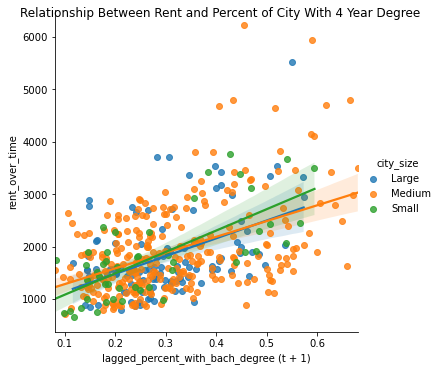

In [7]:
only_2019 = shifted[shifted['year'] == 2019] 
import seaborn as sns
rel1 = sns.lmplot(x = 'lagged_percent_with_bach_degree (t + 1)', y = 'rent_over_time', hue = "city_size", data = only_2019) 
rel1.fig.suptitle('Relationship Between Rent and Percent of City With 4 Year Degree')
plt.show()

The above cell creates a scatterplot between percent of town with a bachelor's degree and the rent over time. This plot shows that there is a correlation between how college educated a city is and how high the rent is.

In addition, we can see how city size relates to that.

I only used 2019 because this plot is only meant for EDA and we are not looking at how the rents change over time in this graph.

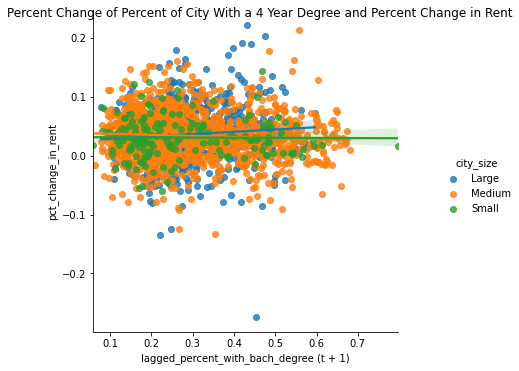

In [8]:
rel2 = sns.lmplot(x = 'lagged_percent_with_bach_degree (t + 1)', y = 'pct_change_in_rent', hue = "city_size", data = shifted)
rel2.fig.suptitle('Percent Change of Percent of City With a 4 Year Degree and Percent Change in Rent')
plt.show()

The above scatterplot shows a scatterplot between the percent change of city population with a bachelor's degree and the percent change in rent. It is clear that there is no (or a very small) linear correlation. Given this fact, I will look for non-linear relationships, while accounting for rent and total population.

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'year'),
  Text(1.5, 0, 'percent_of_town_with_bachelor_degree_for_year_x'),
  Text(2.5, 0, 'total_pop'),
  Text(3.5, 0, 'rent_over_time'),
  Text(4.5, 0, 'lagged_percent_with_bach_degree (t + 1)'),
  Text(5.5, 0, 'pct_change_of_pop_with_bach_degree'),
  Text(6.5, 0, 'pct_change_in_rent'),
  Text(7.5, 0, 'Average_Rent_of_City')])

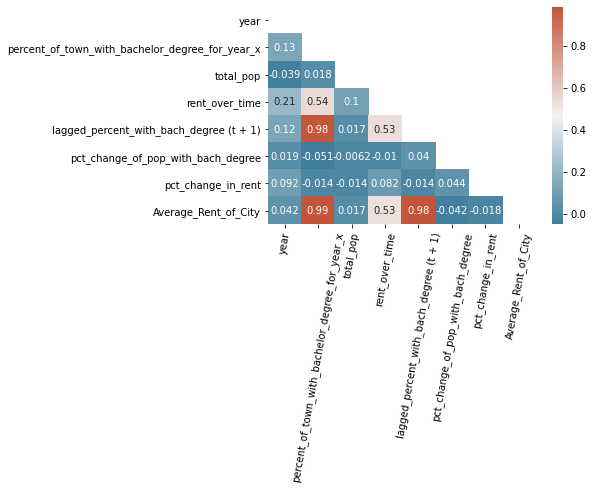

In [9]:
corr = shifted.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
plt.xticks(rotation = 80)

As you can see, the percent change in rent is very loosely correlated with the percent change in rent and the percent change of number of college graduates moving into a city.

Because of the low correlation between the percent change of people with bachelor degrees in a city and the percent change in price, we know the relationship (if there is one) must not be linear. That is, if there is correlation between an indendent and dependent variable, that does not imply there is a casual relationship. But, if there is *no* correlation, there *cannot* be a linear casual relationship. Thus, I must try to fit a non-linear model onto this data. I will use the random forest regression algorithm, which is a series of decision trees with the results averaged.

In [10]:
x1, x2, x3, y = shifted['lagged_percent_with_bach_degree (t + 1)'], shifted['Average_Rent_of_City'], shifted['total_pop'],shifted['pct_change_in_rent']
x1, x2, x3, y  = np.array(x1), np.array(x2), np.array(x3),np.array(y)
x1, x2, x3, y  = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), y.reshape(-1, 1)
final_x = np.concatenate((x1, x2, x3), axis = 1)
final_x

array([[1.99200000e-01, 2.33930277e-01, 1.66050000e+05],
       [2.28200000e-01, 2.44375071e-01, 1.49596000e+05],
       [3.33200000e-01, 3.60384186e-01, 1.80084000e+05],
       ...,
       [4.95934876e-01, 5.03921033e-01, 2.19343000e+05],
       [2.22037921e-01, 2.08400603e-01, 4.40652000e+05],
       [2.12958354e-01, 2.33708486e-01, 5.46360000e+04]])

The above cell prepares my data to be processed in the algorithm. The random forest algorithm takes arrays, not dataframe columns, which explains the above code.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import r2_score

x_train, x_test, y_train, y_test = train_test_split(final_x, y, test_size=0.2)
rf = RandomForestRegressor()
random_grid = {'n_estimators': [10, 50, 100, 200, 500],
               'max_features': [1,2,3],
               'max_depth': [1,2,3],
               'min_samples_split': [1,2],
               'min_samples_leaf': [1,2],
               'bootstrap': [True, False]}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, n_jobs = -1)
rf_random.fit(x_train, y_train)
y_pred = rf_random.predict(x_test)
r2_score(y_test, y_pred)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


0.0022491328004580202

[Text(0.5, 0.875, 'lagged_percent_with_bach_degree (t + 1) <= 0.446\nsquared_error = 0.002\nsamples = 1812\nvalue = 0.034'),
 Text(0.25, 0.625, 'lagged_percent_with_bach_degree (t + 1) <= 0.441\nsquared_error = 0.002\nsamples = 1559\nvalue = 0.035'),
 Text(0.125, 0.375, 'total_pop <= 6789693.5\nsquared_error = 0.002\nsamples = 1547\nvalue = 0.035'),
 Text(0.0625, 0.125, 'squared_error = 0.002\nsamples = 1546\nvalue = 0.035'),
 Text(0.1875, 0.125, 'squared_error = -0.0\nsamples = 1\nvalue = -0.054'),
 Text(0.375, 0.375, 'lagged_percent_with_bach_degree (t + 1) <= 0.441\nsquared_error = 0.003\nsamples = 12\nvalue = 0.065'),
 Text(0.3125, 0.125, 'squared_error = 0.0\nsamples = 1\nvalue = 0.19'),
 Text(0.4375, 0.125, 'squared_error = 0.002\nsamples = 11\nvalue = 0.054'),
 Text(0.75, 0.625, 'lagged_percent_with_bach_degree (t + 1) <= 0.46\nsquared_error = 0.002\nsamples = 253\nvalue = 0.027'),
 Text(0.625, 0.375, 'Average_Rent_of_City <= 0.512\nsquared_error = 0.004\nsamples = 27\nvalue = -

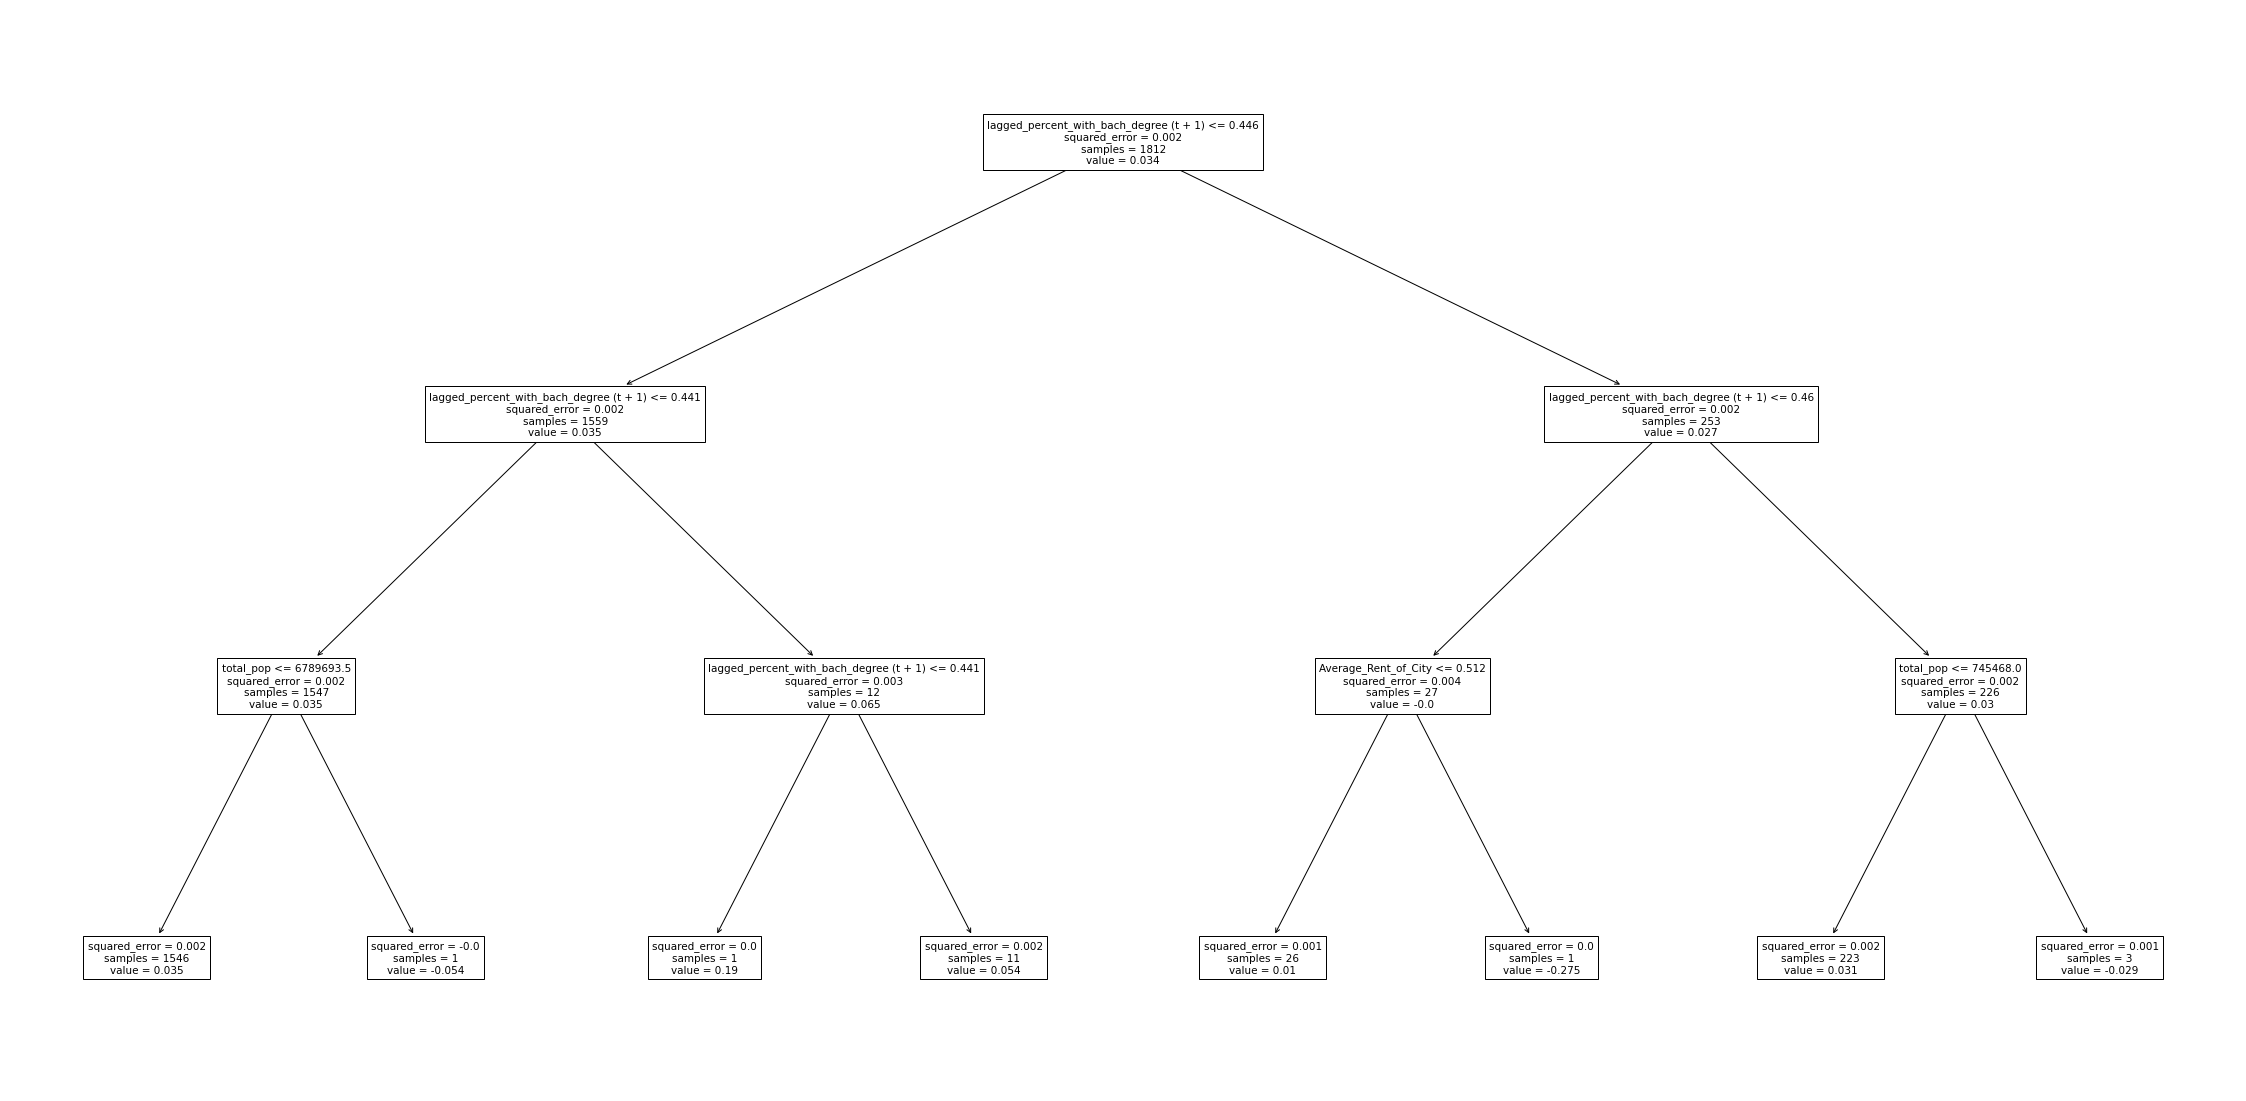

In [16]:
single_tree = tree.DecisionTreeRegressor(max_depth=3)
single_tree.fit(x_train, y_train)
plt.figure(figsize=(40, 20))
tree.plot_tree(single_tree, feature_names = ['lagged_percent_with_bach_degree (t + 1)', 'Average_Rent_of_City', "total_pop"])

As you can see from the above cells, the random forest regressor found there to be no relationship between the independent and dependent variables. That is, the change in rent (measured in percent) could not be estimated (using the data available) from change in population which had a college degree, city size and average rent of the city. 

Above is a single decision tree plotted to show the mechanism through which we got the estimates. The random forest algorithm is a specified number of decision trees which average the regression results from each to attain a more accurate result. This is technically called bagging and boosting as the underlying data is bootstrapped and the model pursues the most accurate hyperparameters as it iterates through the decision trees.

*Note: there is a very strong correlation between percent of a city with a bachelor's degree (not change, but overall) and rent prices. This is obvious as there is a casual relationship between college degrees and income, and income and ability to pay rent. What my analysis seeks to prove is a relationship between the migration of such people, and it's impact on a city's renting economy.*

# Conclusion

This project sought to discover if there was a relationship between college graduates moving in/out of cities and change in rent prices. My analysis showed there is *not* a relationship between the two. 

The purpose of this project was to discover a novel relationship between two variables: percent change in rent and percent change in college graduates. Thus, it is not suprising that no relationship was discovered. 

This analysis could have been improved if more time data was used (say, the past 3 decades), and every city was evaluated (most cities were omitted because of the inner join). Regardless, the author is confident in there either being a very small relationship beteen the variables in this dataset or none at all. What the author cannot conclude is if more datapoints were introduced, if the non-association would persist.